<a href="https://colab.research.google.com/github/Ramkanc/Capstone_IIITH/blob/Capstone1_RamK_Multi_torch/Capstone1_RamK_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python==4.8.0.76

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


In [2]:
# Import Libraries
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
import pandas as pd

In [3]:
import PIL
from PIL import Image

In [4]:
import cv2

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:10<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [7]:
found_directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
found_files =[f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
print (found_directories)
print (found_files)

['Images']
['captions.txt']


In [18]:
image_dir= os.path.join(path, found_directories[0])
print(image_dir)

/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images


In [19]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_dir):
        """
        Args:
            image_dir (str): Path to the directory with images.
        """
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

    def preprocess_image_opencv(self, image_path):
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not found at {image_path}")

        # Resize to 224x224
        image_resized = cv2.resize(image, (224, 224))

        # Convert from BGR to RGB
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to [0, 1]
        image_normalized = image_rgb / 255.0

        # Reshape to CxHxW
        image_reshaped = np.transpose(image_normalized, (2, 0, 1))

        # Convert to PyTorch tensor
        image_tensor = torch.tensor(image_reshaped, dtype=torch.float32)

        # Normalize using ImageNet mean and std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image_tensor = (image_tensor - mean) / std

        return image_tensor

    def __len__(self):
        # Return the number of images
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image path
        image_path = os.path.join(self.image_dir, self.image_files[idx])

        # Preprocess the image
        image_tensor = self.preprocess_image_opencv(image_path)

        # Return the processed tensor
        return image_tensor

# Define the directory containing images
#image_dir = "path_to_image_directory"  # Replace with your directory




Batch 1:
Shape: torch.Size([16, 3, 224, 224])
Type: torch.float32


In [ ]:
# Create an instance of the custom dataset
dataset = CustomImageDataset(image_dir)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [22]:
# Iterate over the DataLoader
for batch_idx, batch_images in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Shape: {batch_images.shape}")  # Expected: [batch_size, 3, 224, 224]
    print(f"Type: {batch_images.dtype}")  # Expected: torch.float32
    break

Batch 1:
Shape: torch.Size([32, 3, 224, 224])
Type: torch.float32


In [24]:
# Function to display a single image
def show_image(image_tensor):
    # Undo normalization for display (optional if you want raw pixel values)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean  # Denormalize

    # Convert from Tensor (CxHxW) to NumPy array (HxWxC)
    image_numpy = image_tensor.permute(1, 2, 0).numpy()
    image_numpy = np.clip(image_numpy, 0, 1)  # Clip values to [0, 1] for proper display

    # Display the image
    plt.imshow(image_numpy)
    plt.axis('off')

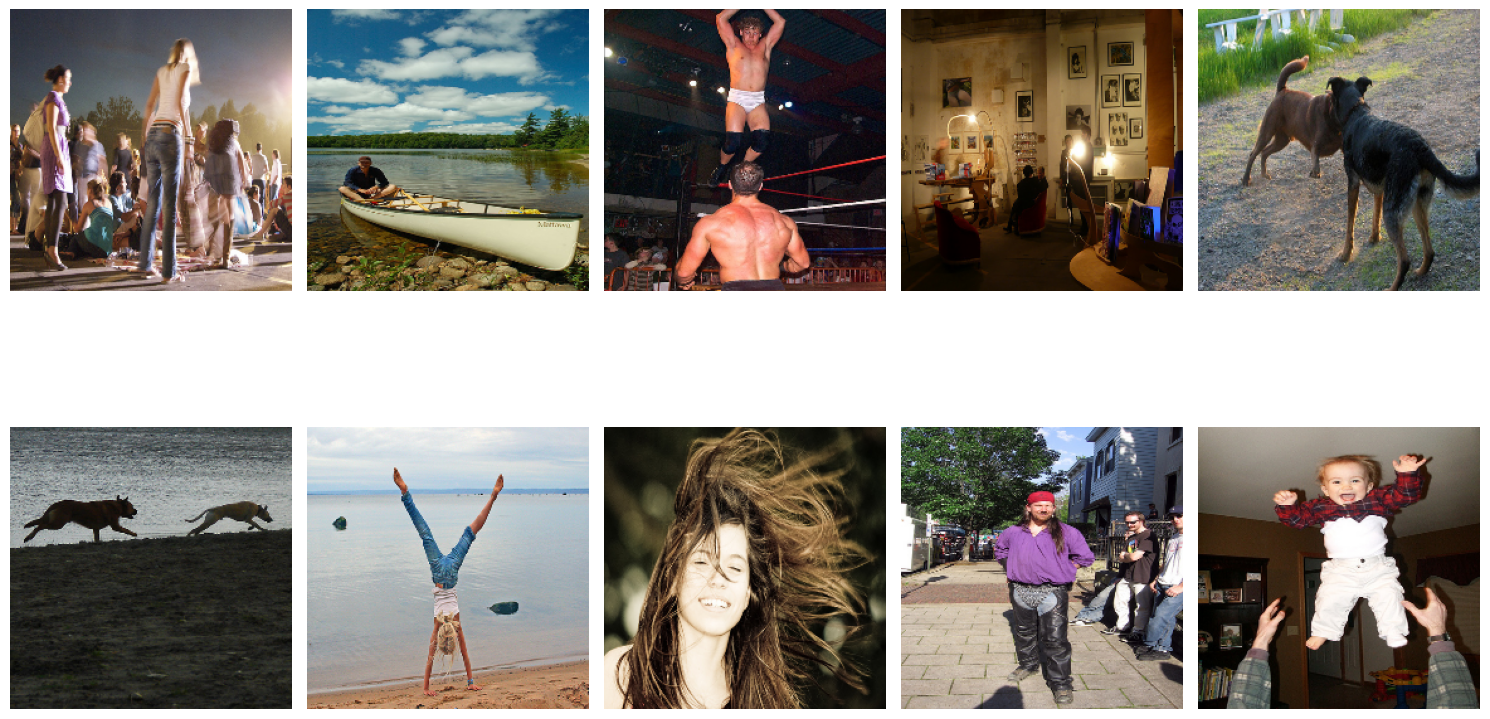

In [25]:
# Iterate through DataLoader and display 10 images
def display_images_from_dataloader(dataloader, num_images=10):
    images_shown = 0
    plt.figure(figsize=(15, 10))  # Adjust figure size for better visualization

    for batch_images in dataloader:
        for image_tensor in batch_images:
            if images_shown >= num_images:
                break
            plt.subplot(2, 5, images_shown + 1)  # Create a 2x5 grid for 10 images
            show_image(image_tensor)
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()

# Call the function to display images
display_images_from_dataloader(dataloader, num_images=10)